# Model Arima for Time Series Forecasting temperature

# LLibreries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

import json
import os

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Model ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from dateutil.relativedelta import relativedelta

# Barra de progresso
# from tqdm import tqdm
from tqdm.notebook import tqdm


# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# Preparació de dades des de JSON 

No cal fer-ho es pot llegir directament des del CSV ja preprocessat


La següent cel·la és per llegir des del CSV

In [ ]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades)

# Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

# Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

# Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'], utc=True)

df = df.sort_values(by='data')

# Eliminem les dades que estan entre hores, es a dir en minuts que no son 0
df = df[df['data'].dt.minute == 0]

# Restablir l'index
df = df.reset_index(drop=True)

df

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


# Carregar dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [ ]:
#Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades_csv = 'SCM_T_Z1.csv'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)

# Llegir el fitxer CSV i importar les dades

df = pd.read_csv(path_dades)

# Convertir la columna 'data' a tipus datetime
df['data'] = pd.to_datetime(df['data'], utc=True)

df

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


# Primera Construcció model ARIMA (sense funció)

In [8]:
# Definim el període de predicció

inici = "2021-01-01 00:00:00+00:00"  
final = "2021-01-02 00:00:00+00:00"  

# Definim finestra d'entrenament (quant de temps enrere volem mirar)

dies_entrenament = 4  # entrenarem amb 90 dies previs (3 mesos)


# Establim les dades d'entrenament i de test per l'ARIMA
data = df.copy()
display(data.head(5))

data_inici_pred = pd.to_datetime(inici)
data_final_pred = pd.to_datetime(final)

data_inici_train = data_inici_pred - pd.Timedelta(days=dies_entrenament)

# Conjunt d'entrenament
data_train = data[(data['data'] >= data_inici_train) & (data['data'] < data_inici_pred)].copy()
# Restablir l'index
data_train = data_train.reset_index(drop=True)

# Conjunt de test (el que volem predir)
data_test = data[(data['data'] >= data_inici_pred) & (data['data'] <= data_final_pred)].copy()
# Restablir l'index
data_test = data_test.reset_index(drop=True)


# Mostrem les dimensions
print(f"Dades d'entrenament: {len(data_train)} valors")
print(f"Dades de test: {len(data_test)} valors")


# # Grafiquem data_train i data_test en el mateix gràfic

# plt.figure(figsize=(15, 5))
# plt.plot(data_train['data'], data_train['valor'], label='Train')
# plt.plot(data_test['data'], data_test['valor'], label='Test')
# plt.xlabel("Data")
# plt.ylabel("Dades Temperatura")
# plt.title("Train i Test")
# plt.legend()
# plt.grid(True)
# plt.show()

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80


Dades d'entrenament: 96 valors
Dades de test: 25 valors


,data,valor,forecast
0,2021-01-01 00:00:00+00:00,-7.40,-6.25
1,2021-01-01 01:00:00+00:00,-7.60,-5.72
2,2021-01-01 02:00:00+00:00,-7.70,-5.43
3,2021-01-01 03:00:00+00:00,-8.00,-5.28
4,2021-01-01 04:00:00+00:00,-8.40,-5.20


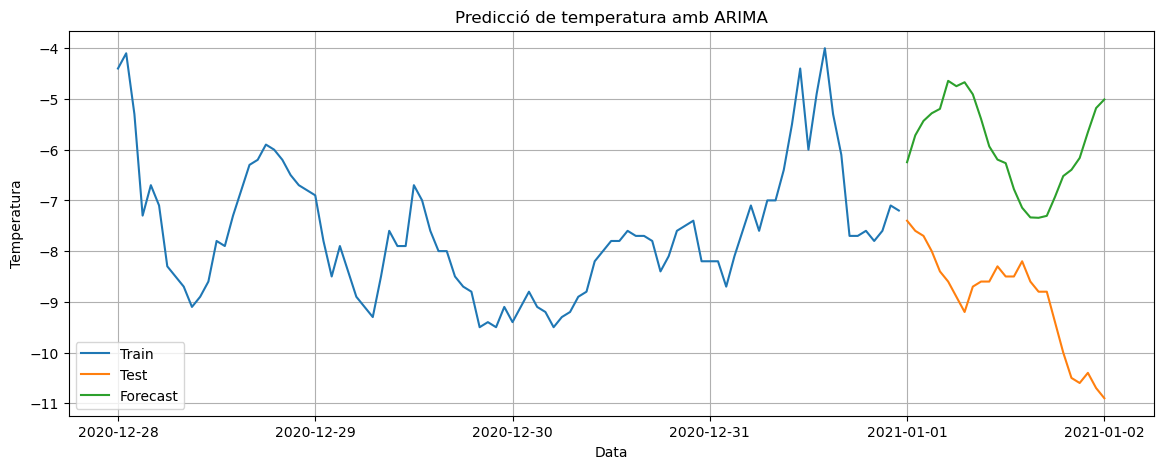

MAE: 3.02 °C
RMSE: 3.31 °C


In [9]:
# Parametres model  

p =  10      # Ordre autoregressiu
d =  1      # Ordre d'integració
q =  10     # Ordre de mitjana mòbil


# Entrenem amb statsmodels

model = ARIMA(data_train['valor'], order=(p, d, q))
model_fit = model.fit()

# print(model_fit.summary())


# Prediccions

data_test_p = data_test.copy()

start = len(data_train) 
n_test = len(data_test)
end = start + n_test - 1

# forecast = model_fit.predict(start=start, end=end, typ='levels')
forecast = model_fit.forecast(steps=n_test)

# Fem de forecast una serie dataframe i resetegem l'index
forecast = pd.DataFrame(forecast)
forecast = forecast.reset_index(drop=True)

data_test_p ['forecast'] = forecast

display(data_test_p.head(5))


# Grafiquem les prediccions 

plt.figure(figsize=(14,5))
plt.plot(data_train['data'], data_train['valor'], label='Train')
plt.plot(data_test_p['data'], data_test_p['valor'], label='Test')
plt.plot(data_test_p['data'], data_test_p['forecast'], label='Forecast')
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.title("Predicció de temperatura amb ARIMA")
plt.legend()
plt.grid(True)
plt.show()


# Mètriques

mae = mean_absolute_error(data_test_p['valor'], data_test_p['forecast'])
rmse = np.sqrt(mean_squared_error(data_test_p['valor'], data_test_p['forecast']))
print(f"MAE: {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")



# Funcions model ARIMA/SARIMA

## Primera funció ARIMA tot junt

In [ ]:
# Funció per fer el model ARIMA, entrenar el model, fer la predicció i graficar

def arima_temp_tot (df, inici, final, dies_entrenament, p,d,q, P=None, D=None, Q=None, s=None, plot_dies_ant=None):

    # Establim les dades d'entrenament i de test per l'ARIMA
    data = df.copy()

    data_inici_pred = pd.to_datetime(inici)
    data_final_pred = pd.to_datetime(final)

    data_inici_train = data_inici_pred - pd.Timedelta(days=dies_entrenament)

    # Conjunt d'entrenament
    data_train = data[(data['data'] >= data_inici_train) & (data['data'] < data_inici_pred)].copy()
    # Restablir l'index
    data_train = data_train.reset_index(drop=True)

    # Conjunt de test (el que volem predir)
    data_test = data[(data['data'] >= data_inici_pred) & (data['data'] <= data_final_pred)].copy()
    # Restablir l'index
    data_test = data_test.reset_index(drop=True)


    # Mostrem les dimensions
    print(f"Dades d'entrenament: {len(data_train)} valors")
    print(f"Dades de test: {len(data_test)} valors")

    # Entrenem amb statsmodels

    if None not in (P, D, Q, s):
        model = SARIMAX(data_train['valor'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    else:
        model = SARIMAX(data_train['valor'], order=(p, d, q))

    model_fit = model.fit()

    # print(model_fit.summary())


    # Prediccions

    data_test_p = data_test.copy()

    # # Metode predicció 1 --> Funció predict
    # start = len(data_train) 
    # end = start + n_test - 1
    # forecast = model_fit.predict(start=start, end=end, typ='levels')

    # Metode predicció 2 --> Funció forecast
    n_test = len(data_test)
    forecast = model_fit.forecast(steps=n_test)

    # Fem de forecast una serie dataframe i resetegem l'index
    forecast = pd.DataFrame(forecast)
    forecast = forecast.reset_index(drop=True)

    data_test_p ['forecast'] = forecast

    display(data_test_p.head(5))


    # Afegim els dies previs si s'indiquen
    if plot_dies_ant is not None:
        data_inici_plot = data_inici_pred - pd.Timedelta(days = plot_dies_ant)
        data_train_plot = data[(data['data'] >= data_inici_plot) & (data['data'] < data_inici_pred)].copy()

    # Grafiquem les prediccions 

    plt.figure(figsize=(14,5))
    if plot_dies_ant is not None:
        plt.plot(data_train_plot['data'], data_train_plot['valor'], label='Train')
    plt.plot(data_test_p['data'], data_test_p['valor'], label='Test')
    plt.plot(data_test_p['data'], data_test_p['forecast'], label='Forecast')
    plt.xlabel("Data")
    plt.ylabel("Temperatura")
    plt.title("Predicció de temperatura amb ARIMA")
    plt.legend()
    plt.grid(True)
    plt.show()


    # Mètriques

    mae = mean_absolute_error(data_test_p['valor'], data_test_p['forecast'])
    rmse = np.sqrt(mean_squared_error(data_test_p['valor'], data_test_p['forecast']))
    print(f"MAE: {mae:.2f} °C")
    print(f"RMSE: {rmse:.2f} °C")

    return


## Funcions Modulars ARIMA/SARIMA

In [4]:
# Funció que només entrena el model ARIMA/SARIMA/SARIMAX, segons les variables que se li posen, i retorna el model entrenat 

def arima_temp_train (df, inici, dies_entrenament, p,d,q, P=None, D=None, Q=None, s=None, verbose=False):

    # Establim les dades d'entrenament i de test per l'ARIMA
    data = df.copy()

    data_inici_pred = pd.to_datetime(inici)
    data_inici_train = data_inici_pred - pd.Timedelta(days=dies_entrenament)
    
    
    # Conjunt d'entrenament
    data_train = data[(data['data'] >= data_inici_train) & (data['data'] < data_inici_pred)].copy()
    data_train = data_train.reset_index(drop=True) # Restablir l'index

    # Conjunt de test (el que volem predir)
    data_test = data[(data['data'] >= data_inici_pred)].copy()
    data_test = data_test.reset_index(drop=True) # Restablir l'index


    # Mostrem les dimensions
    if verbose:
        print(f"Dades d'entrenament: {len(data_train)} valors")
    else:    
        pass


    # Entrenem amb statsmodels
    if None not in (P, D, Q, s):

        if verbose:
            print(f"Entrenant SARIMA amb seasonal_order=({P},{D},{Q},{s})")
        else:
            pass

        # Si hi ha component estacional, fem servir SARIMA
        model = SARIMAX(data_train['valor'], order=(p, d, q), seasonal_order=(P, D, Q, s))

    else:

        if verbose:
            print(f"Entrenant ARIMA sense component estacional")

        else:
            pass

        # Si no hi ha component estacional, fem servir ARIMA
        model = SARIMAX(data_train['valor'], order=(p, d, q))
        
        
    model_fit = model.fit()

    # print(model_fit.summary())

    return model_fit


In [5]:

# Funció que fa la predicció amb el model ARIMA/SARIMA/SARIMAX entrenat i retorna les mètriques

def arima_temp_forecast (df, model_fit, inici_pred, n_hores, plot_dies_ant = None):

    data = df.copy()
    data_inici_pred = pd.to_datetime(inici_pred)

    # Creem el DataFrame de test amb les dates i valors reals
    data_test = data[(data['data'] >= data_inici_pred)].copy()
    data_test = data_test.reset_index(drop=True)
    data_test = data_test.iloc[:n_hores].copy()  # Ens quedem només amb els n_steps

    # Fem la predicció
    forecast = model_fit.forecast(steps=n_hores)

    # Afegim la predicció al mateix DataFrame
    data_test['forecast'] = forecast.values


    # Preview
    display(data_test.head(5))



    # Afegim els dies previs si s'indiquen
    if plot_dies_ant is not None:
        data_inici_plot = data_inici_pred - pd.Timedelta(days = plot_dies_ant)
        data_train_plot = data[(data['data'] >= data_inici_plot) & (data['data'] < data_inici_pred)].copy()

    # Gràfic
    plt.figure(figsize=(14,5))
    if plot_dies_ant is not None:
        plt.plot(data_train_plot['data'], data_train_plot['valor'], label='Train')
    plt.plot(data_test['data'], data_test['valor'], label='Real')
    plt.plot(data_test['data'], data_test['forecast'], label='Forecast')
    plt.xlabel("Data")
    plt.ylabel("Temperatura")
    plt.title("Predicció de temperatura amb ARIMA")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mètriques
    mae = mean_absolute_error(data_test['valor'], data_test['forecast'])
    rmse = np.sqrt(mean_squared_error(data_test['valor'], data_test['forecast']))
    print(f"MAE: {mae:.2f} °C")
    print(f"RMSE: {rmse:.2f} °C")

    return 

## Funcions ARIMA/SARIMA amb rolling forecast 

Funcions ARIMA/SARIMA amb rolling forecast, es a dir, amb reentrenament cada cop que obtenim una dada per predir t+1.

In [13]:
def arima_rolling_forecast (df, data_inici_pred, n_hores, dies_entrenament, p, d, q, P=None, D=None, Q=None, s=None, plot_dies_ant=None):

    dates = pd.date_range(start=data_inici_pred, periods=n_hores, freq='H')


    # Creem el data test general, resultat final a omplir
    data = df.copy()
    data_inici_pred = pd.to_datetime(data_inici_pred)
    data_test = data[(data['data'] >= data_inici_pred) & (data['data'] < data_inici_pred + pd.Timedelta(hours=n_hores))].copy()
    data_test = data_test.reset_index(drop=True) # Restablir l'index

    # Afegim columna de forecast on despres del loop hi posarem les prediccions de cada iteracio
    data_test['forecast'] = np.nan

    # Creem la llista forecast on afegirem les n prediccions i despres les afegirem al dataframe test
    forecast = []

    for date_roll in tqdm(dates, desc = "Rolling Forecast"):

        # Entrenem el model amb la funcio arima_temp_train cada cop variant la data d'inici
        model_fit = arima_temp_train(df, date_roll, dies_entrenament, p, d, q, P, D, Q, s)


        # Preparem per fer la predicció
        forecast_value = model_fit.forecast(steps=1)

        # Afegim la predicció a la llista
        forecast.append(forecast_value.values[0])



    # Un cop acabat el loop, afegim la llista de prediccions al dataframe test
    data_test['forecast'] = forecast

    # Plotegem el resultat
    plt.figure(figsize=(14,5))

    if plot_dies_ant is not None:
        data_inici_plot = data_inici_pred - pd.Timedelta(days = plot_dies_ant)
        data_train_plot = data[(data['data'] >= data_inici_plot) & (data['data'] < data_inici_pred)].copy()
        plt.plot(data_train_plot['data'], data_train_plot['valor'], label='Train')


    plt.plot(data_test['data'], data_test['valor'], label='Real')
    plt.plot(data_test['data'], data_test['forecast'], label='Forecast')
    plt.xlabel("Data")
    plt.ylabel("Temperatura")
    plt.title("Predicció de temperatura amb ARIMA")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mètriques
    mae = mean_absolute_error(data_test['valor'], data_test['forecast'])
    rmse = np.sqrt(mean_squared_error(data_test['valor'], data_test['forecast']))

    display(data_test.head(5))
    print(f"MAE: {mae:.2f} °C")
    print(f"RMSE: {rmse:.2f} °C")

    return 

   

# Proves Models ARIMA

In [ ]:
# Definim la data limite de predicció
data_inici_pred = "2021-05-05 00:00:00+00:00"
dies_entrenament = 180

# Parametres del model ARIMA
p =  30     # Ordre autoregressiu (hores passades utilitzades per predir)
d =  1      # Ordre d'integració
q =  p     # Ordre de mitjana mòbil (nombre de errors passats utilitzats per predir)

# Entrenament del model ARIMA

model_fit = arima_temp_train(df, data_inici_pred, dies_entrenament, p, d, q, verbose=True)


Dades d'entrenament: 4320 valors
Dades de test: 25 valors
Entrenant ARIMA sense component estacional


In [16]:
# Forecast i plot del model

data_inici_pred = "2021-05-05 00:00:00+00:00"

n_dies_pred = 1 # Nombre de dies a predir
n_hores = round(n_dies_pred * 24) # Nombre d'hores a predir
plot_dies_ant = 5 # Nombre de dies a mostrar en el gràfic

arima_temp_forecast(df, model_fit, data_inici_pred, n_hores, plot_dies_ant = plot_dies_ant)

NameError: name 'model_fit' is not defined

# Proves Model SARIMA

In [ ]:
# Definim la data limite de predicció
data_inici_pred = "2021-05-05 00:00:00+00:00"
dies_entrenament = 180

# Parametres del model ARIMA
p =  12     # Ordre autoregressiu (hores passades utilitzades per predir)
d =  1      # Ordre d'integració
q =  p     # Ordre de mitjana mòbil (nombre de errors passats utilitzats per predir)


# Parametres de Sesionalitat per SARIMA
P = 1      # Ordre autoregressiu estacional
D = 1      # Ordre d'integració estacional
Q = 1      # Ordre de mitjana mòbil estacional
s = 24     # Nombre de períodes en un cicle estacional (24 hores en un dia)

# Entrenament del model ARIMA

model_fit = arima_temp_train(df, data_inici_pred, dies_entrenament, p, d, q, P, D, Q, s, verbose=True)


Dades d'entrenament: 4320 valors
Dades de test: 25 valors
Entrenant SARIMA amb seasonal_order=(1,1,1,24)


,data,valor,forecast
0,2021-05-05 00:00:00+00:00,2.50,2.19
1,2021-05-05 01:00:00+00:00,2.20,2.12
2,2021-05-05 02:00:00+00:00,1.20,2.07
3,2021-05-05 03:00:00+00:00,1.30,1.89
4,2021-05-05 04:00:00+00:00,1.20,1.69


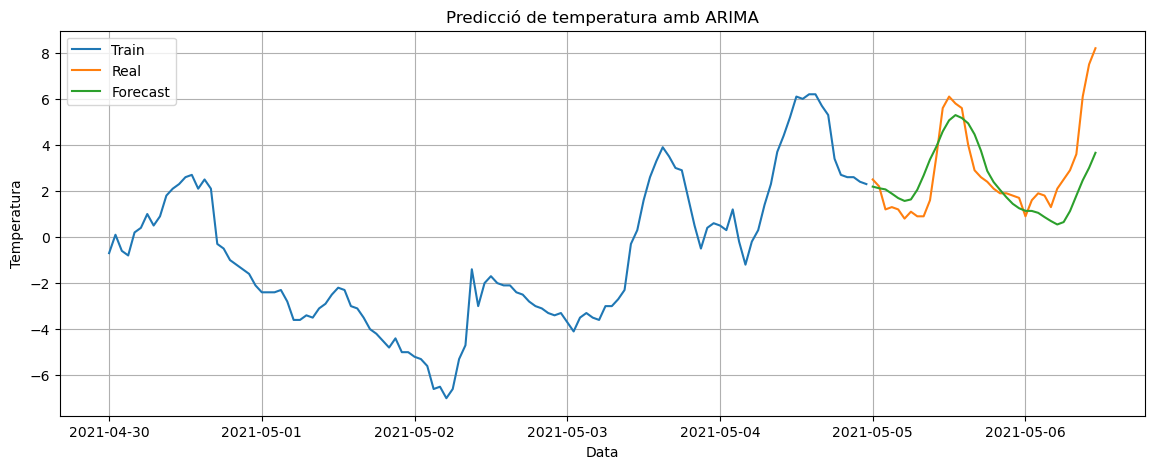

MAE: 1.11 °C
RMSE: 1.55 °C


In [75]:
# Forecast i plot del model

data_inici_pred = "2021-05-05 00:00:00+00:00"

n_dies_pred = 1.5 # Nombre de dies a predir
n_hores = round(n_dies_pred * 24) # Nombre d'hores a predir
plot_dies_ant = 5 # Nombre de dies a mostrar en el gràfic

arima_temp_forecast(df, model_fit, data_inici_pred, n_hores, plot_dies_ant = plot_dies_ant)

## Proves Arima amb rolling forecast

Rolling Forecast:   0%|          | 0/240 [00:00<?, ?it/s]

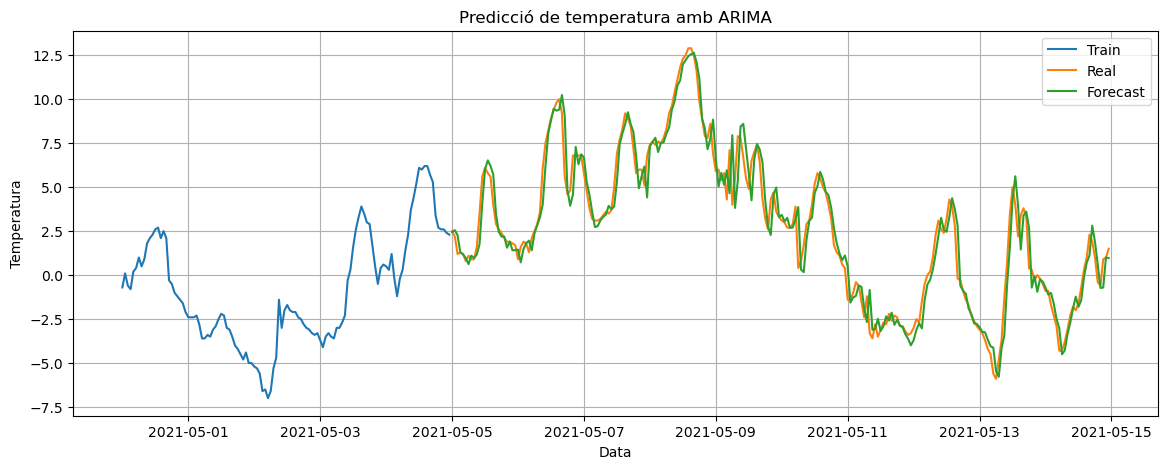

,data,valor,forecast
0,2021-05-05 00:00:00+00:00,2.50,2.44
1,2021-05-05 01:00:00+00:00,2.20,2.56
2,2021-05-05 02:00:00+00:00,1.20,2.27
3,2021-05-05 03:00:00+00:00,1.30,1.29
4,2021-05-05 04:00:00+00:00,1.20,1.18


MAE: 0.69 °C
RMSE: 0.97 °C


In [15]:
# Definim la data limite de predicció
data_inici_pred = "2021-05-05 00:00:00+00:00"
dies_entrenament = 10

# Parametres del model ARIMA
p =  5     # Ordre autoregressiu (hores passades utilitzades per predir)
d =  1      # Ordre d'integració
q =  p     # Ordre de mitjana mòbil (nombre de errors passats utilitzats per predir)


# Parametres de Sesionalitat per SARIMA
P = 1      # Ordre autoregressiu estacional
D = 1      # Ordre d'integració estacional
Q = 1      # Ordre de mitjana mòbil estacional
s = 10    # Nombre de períodes en un cicle estacional (24 hores en un dia)


n_dies = 10
n_hores = round(n_dies * 24) # Nombre d'hores a predir

# n_hores = 48 # Nombre d'hores a predir


# Entrenament del model ARIMA

arima_rolling_forecast(df, data_inici_pred, n_hores=n_hores, dies_entrenament=dies_entrenament, p=p, d=d, q=q, P=None, D=None, Q=None, s=None, plot_dies_ant=5)